In [81]:
# creative prompts

creative_prompts = ["Write a poem", "Tell me a joke", "Describe the feeling of love", "Write a story starting with 'Once upon a time...'",
                    "Tell a story about a dog", "Write a song", "Write a poem about a robot", "Invent an original recipe",
                    "Imagine a new object and describe what it looks like", "Imagine a new philosophy and describe it"]

# factual prompts
factual_prompts = ["What is the capital of France?", "How is H2O commonly known?", "What is the largest country in the world?", "How many days are in a year?",
                   "What is the largest planet in the solar system?", "What is the largest animal in the world?", "How do you say hello in Spanish?", "Who won the 2018 World Cup?",
                   "What is the biggest city in Europe?", "What is the largest country in Africa?"]





In [82]:
from nltk.translate.bleu_score import sentence_bleu
#TODO check that it matches fairseq self-BLEU
def self_BLEU(sentences):
    scores = []
    for i in range(len(sentences)):
        score = sentence_bleu(sentences[:i] + sentences[i+1:], sentences[i])
        scores.append(score)
    return np.mean(scores)

In [106]:
def format_prompt_llama2(prompt):
    prompt_format = """<s>[INST] <<SYS>>
    You are a helpful, respectful and honest assistant. Always answer without asking questions or clarifications.
    <</SYS>>

    {} [/INST]"""
    return prompt_format.format(prompt)

def format_prompt_vicuna(prompt, version="1.5"):
    model_path = "lmsys/vicuna-7b-v" + version
    conv = get_conversation_template(model_path)
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    full_prompt = conv.get_prompt()
    return full_prompt

#prompt = prompt_format.format("What is the best way to get to the airport?")
#input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
#output_ids = model.generate(input_ids, max_length=300, pad_token_id=tokenizer.eos_token_id, do_sample=True, temperature=1.2, num_return_sequences=2)

#print(tokenizer.decode(output_ids[0], skip_special_tokens=True))


In [105]:
def generate_one_sample(prompt, model, temperature):
    if model == "llama2-chat":
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        full_prompt = format_prompt_llama2(prompt)
    elif model == "vicuna1.5":
        model_path = "lmsys/vicuna-7b-v1.5"
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        #adapted from https://github.com/lm-sys/FastChat/blob/a47b8f9e93c8b5a85e81d1ae33e3a1106d8cdf80/fastchat/serve/huggingface_api.py
        full_prompt = format_prompt_vicuna(prompt)
    model.to("cuda:0")
    input_ids = tokenizer.encode(full_prompt, return_tensors="pt").to("cuda:0")
    output = model.generate(
        input_ids,
        do_sample=True,
        num_return_sequences=5,
        max_length=150,
        temperature=temperature,
    )
    return prompt, tokenizer.batch_decode(output, skip_special_tokens=True)

# launch with submitit
executor = submitit.AutoExecutor(folder="logs")
executor.update_parameters(timeout_min=60, slurm_partition="parietal,gpu,normal", gpus_per_node=1,
                            # exclude nodes
                            exclude="margpu002,margpu003")
job = executor.submit(generate_one_sample, "Imagine a new object and describe what it looks like", "llama2-chat", 0.9)

# print results
print(job.result())
    


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 17:40:41,012) - Call #347 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', 

submitit WARNING (2023-08-08 17:40:41,012) - Call #347 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', '1334668', '-j', '1334593', '-j', '1336768', '-j', '1335524', '-j', '1336670', '-j', '1334584', '-j', '1336765', '-j', '1335841', '-j', '1334552', '-j', '1334715', '-j', '1334907', '-j', '1335964', '-j', '1335565', '-j', '1336723', '-j', '1336751', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 17:40:43,025) - Call #348 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', 

submitit WARNING (2023-08-08 17:40:43,025) - Call #348 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', '1334668', '-j', '1334593', '-j', '1336768', '-j', '1335524', '-j', '1336670', '-j', '1334584', '-j', '1336765', '-j', '1335841', '-j', '1334552', '-j', '1334715', '-j', '1334907', '-j', '1335964', '-j', '1335565', '-j', '1336723', '-j', '1336751', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 17:40:46,040) - Call #349 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', 

submitit WARNING (2023-08-08 17:40:46,040) - Call #349 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', '1334668', '-j', '1334593', '-j', '1336768', '-j', '1335524', '-j', '1336670', '-j', '1334584', '-j', '1336765', '-j', '1335841', '-j', '1334552', '-j', '1334715', '-j', '1334907', '-j', '1335964', '-j', '1335565', '-j', '1336723', '-j', '1336751', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 17:40:52,059) - Call #350 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', 

submitit WARNING (2023-08-08 17:40:52,059) - Call #350 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', '1334668', '-j', '1334593', '-j', '1336768', '-j', '1335524', '-j', '1336670', '-j', '1334584', '-j', '1336765', '-j', '1335841', '-j', '1334552', '-j', '1334715', '-j', '1334907', '-j', '1335964', '-j', '1335565', '-j', '1336723', '-j', '1336751', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 17:41:04,093) - Call #351 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', 

submitit WARNING (2023-08-08 17:41:04,093) - Call #351 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', '1334668', '-j', '1334593', '-j', '1336768', '-j', '1335524', '-j', '1336670', '-j', '1334584', '-j', '1336765', '-j', '1335841', '-j', '1334552', '-j', '1334715', '-j', '1334907', '-j', '1335964', '-j', '1335565', '-j', '1336723', '-j', '1336751', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 17:41:28,150) - Call #352 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', 

submitit WARNING (2023-08-08 17:41:28,150) - Call #352 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1334561', '-j', '1334446', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1334436', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334670', '-j', '1334658', '-j', '1335596', '-j', '1335614', '-j', '1335525', '-j', '1335595', '-j', '1335840', '-j', '1335613', '-j', '1336722', '-j', '1336703', '-j', '1334906', '-j', '1334525', '-j', '1334604', '-j', '1335963', '-j', '1334879', '-j', '1335774', '-j', '1336753', '-j', '1335519', '-j', '1334871', '-j', '1334691', '-j', '1335586', '-j', '1336644', '-j', '1334671', '-j', '1335518', '-j', '1334571', '-j', '1334243', '-j', '1334668', '-j', '1334593', '-j', '1336768', '-j', '1335524', '-j', '1336670', '-j', '1334584', '-j', '1336765', '-j', '1335841', '-j', '1334552', '-j', '1334715', '-j', '1334907', '-j', '1335964', '-j', '1335565', '-j', '1336723', '-j', '1336751', '-j', '

In [114]:
# Use submitit to run this script on a cluster

import submitit
import os
from fastchat.model import get_conversation_template

import numpy as np

# each temperature and for each prompt, generate n_generations samples
temperatures = [k / 10. for k in range(1, 16)]
print(temperatures)
models = ["llama2-chat", "vicuna1.5"]
n_generations = 25
bleu_scores_creative = np.zeros((len(temperatures), len(creative_prompts), len(models)))
bleu_scores_factual = np.zeros((len(temperatures), len(factual_prompts), len(models)))


# define the function to be submitted
def generate_samples(args):
    max_return_sequences = 5 #for memory reasons, we generate the samples in batches of 5
    i, prompt, temperatures, model_name = args
    if model_name == "llama2-chat":
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
        full_prompt = format_prompt_llama2(prompt)
    elif model_name == "vicuna1.5":
        model_path = "lmsys/vicuna-7b-v1.5"
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        #adapted from https://github.com/lm-sys/FastChat/blob/a47b8f9e93c8b5a85e81d1ae33e3a1106d8cdf80/fastchat/serve/huggingface_api.py
        full_prompt = format_prompt_vicuna(prompt)
    model.to("cuda:0")
    input_ids = tokenizer.encode(full_prompt, return_tensors="pt").to("cuda:0")
    bleu_scores = []
    for temperature in temperatures:
        samples = []
        for _ in range(n_generations // max_return_sequences):
            samples.extend(model.generate(input_ids, temperature=temperature, max_length=input_ids.shape[1] + 120,
                                            num_return_sequences=max_return_sequences, do_sample=True))
        # remove prompt from the samples
        samples = [sample[input_ids.shape[1]:] for sample in samples]
        samples = [tokenizer.decode(sample, skip_special_tokens=True) for sample in samples]
        print(f"Model: {model_name}")
        print(f"Prompt: {prompt}")
        print(f"Temperature: {temperature}")
        print(f"Samples: {samples}")
        bleu_score = self_BLEU(samples)
        print(f"BLEU score: {bleu_score}")
        bleu_scores.append(bleu_score)
    return bleu_scores

# create a folder for the logs of the submitted jobs
os.makedirs("logs", exist_ok=True)


for model in models:
    # create a submitit executor
    executor = submitit.AutoExecutor(folder="logs")

    # specify the parameters for the Slurm job
    #exclude margpu002 and margpu003
    executor.update_parameters(timeout_min=60, slurm_partition="parietal,gpu,normal", gpus_per_node=1,
                                # exclude nodes
                                exclude="margpu002,margpu003")
    
    # For creative prompts
    args_list_creative = [(i, prompt, temperatures, model) for i, prompt in enumerate(creative_prompts)]
    jobs_creative = executor.map_array(generate_samples, args_list_creative)

    # For factual prompts
    args_list_factual = [(i, prompt, temperatures, model) for i, prompt in enumerate(factual_prompts)]
    jobs_factual = executor.map_array(generate_samples, args_list_factual)

    # Collect the results for creative prompts
    for i, job in enumerate(jobs_creative):
        bleu_scores = job.result()
        for t_index, score in enumerate(bleu_scores):
            bleu_scores_creative[t_index, i, models.index(model)] = score

    # Collect the results for factual prompts
    for i, job in enumerate(jobs_factual):
        bleu_scores = job.result()
        for t_index, score in enumerate(bleu_scores):
            bleu_scores_factual[t_index, i, models.index(model)] = score

# Save the results
np.save("bleu_scores_creative_max_length120.npy", bleu_scores_creative)
np.save("bleu_scores_factual_max_length120.npy", bleu_scores_factual)



/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:22:33,150) - Call #382 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', 

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
submitit WARNING (2023-08-08 18:22:33,150) - Call #382 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691',

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:22:35,163) - Call #383 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', 

submitit WARNING (2023-08-08 18:22:35,163) - Call #383 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '1334552', '-j', '1336829', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:22:38,178) - Call #384 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', 

submitit WARNING (2023-08-08 18:22:38,178) - Call #384 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '1334552', '-j', '1336829', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:22:44,198) - Call #385 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', 

submitit WARNING (2023-08-08 18:22:44,198) - Call #385 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '1334552', '-j', '1336829', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:22:56,231) - Call #386 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', 

submitit WARNING (2023-08-08 18:22:56,231) - Call #386 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '1334552', '-j', '1336829', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:23:20,290) - Call #387 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', 

submitit WARNING (2023-08-08 18:23:20,290) - Call #387 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '1334552', '-j', '1336829', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:24:08,400) - Call #388 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', 

submitit WARNING (2023-08-08 18:24:08,400) - Call #388 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '1334552', '-j', '1336829', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:25:44,614) - Call #389 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', 

submitit WARNING (2023-08-08 18:25:44,614) - Call #389 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '1334552', '-j', '1336829', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:28:57,041) - Call #390 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', 

submitit WARNING (2023-08-08 18:28:57,041) - Call #390 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '1334552', '-j', '1336829', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:35:21,920) - Call #391 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', 

submitit WARNING (2023-08-08 18:35:21,920) - Call #391 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '1334552', '-j', '1336829', '-j', '

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:39:42,612) - Call #392 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', 

submitit WARNING (2023-08-08 18:39:42,612) - Call #392 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:39:44,625) - Call #393 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', 

submitit WARNING (2023-08-08 18:39:44,625) - Call #393 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:39:47,639) - Call #394 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', 

submitit WARNING (2023-08-08 18:39:47,639) - Call #394 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:39:53,660) - Call #395 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', 

submitit WARNING (2023-08-08 18:39:53,660) - Call #395 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:40:05,693) - Call #396 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', 

submitit WARNING (2023-08-08 18:40:05,693) - Call #396 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:40:29,752) - Call #397 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', 

submitit WARNING (2023-08-08 18:40:29,752) - Call #397 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:41:17,887) - Call #398 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', 

submitit WARNING (2023-08-08 18:41:17,887) - Call #398 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:42:54,104) - Call #399 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', 

submitit WARNING (2023-08-08 18:42:54,104) - Call #399 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:46:06,525) - Call #400 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', 

submitit WARNING (2023-08-08 18:46:06,525) - Call #400 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

sacct: error: slurm_persist_conn_open_without_init: failed to open persistent connection to host:localhost:6819: Connection refused
sacct: error: Sending PersistInit msg: Connection refused
sacct: error: Problem talking to the database: Connection refused
submitit WARNING (2023-08-08 18:52:31,398) - Call #401 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', 

submitit WARNING (2023-08-08 18:52:31,398) - Call #401 - Bypassing sacct error Command '['sacct', '-o', 'JobID,State,NodeList', '--parsable2', '-j', '1336770', '-j', '1336703', '-j', '1335613', '-j', '1336830', '-j', '1334525', '-j', '1336753', '-j', '1335586', '-j', '1336644', '-j', '1334571', '-j', '1334584', '-j', '1336765', '-j', '1335964', '-j', '1335565', '-j', '1336751', '-j', '1335521', '-j', '1336853', '-j', '1336645', '-j', '1334436', '-j', '1336791', '-j', '1336792', '-j', '1335614', '-j', '1335840', '-j', '1334604', '-j', '1335963', '-j', '1334871', '-j', '1335524', '-j', '1336723', '-j', '1336852', '-j', '1334447', '-j', '1334887', '-j', '1336779', '-j', '1334933', '-j', '1336754', '-j', '1334468', '-j', '1334577', '-j', '1335773', '-j', '1334888', '-j', '1336669', '-j', '1335566', '-j', '1336704', '-j', '1335585', '-j', '1334658', '-j', '1335525', '-j', '1335596', '-j', '1334906', '-j', '1335519', '-j', '1335774', '-j', '1334691', '-j', '1334593', '-j', '1336815', '-j', '

In [113]:
bleu_scores_creative[:, 5, 0]

array([1.        , 0.99992165, 0.98000059, 0.9857906 , 0.96802345,
       0.96263776, 0.97224631, 0.94884078, 0.95667176, 0.94294311,
       0.94286534, 0.92300934, 0.90535034, 0.93257459, 0.9100669 ])

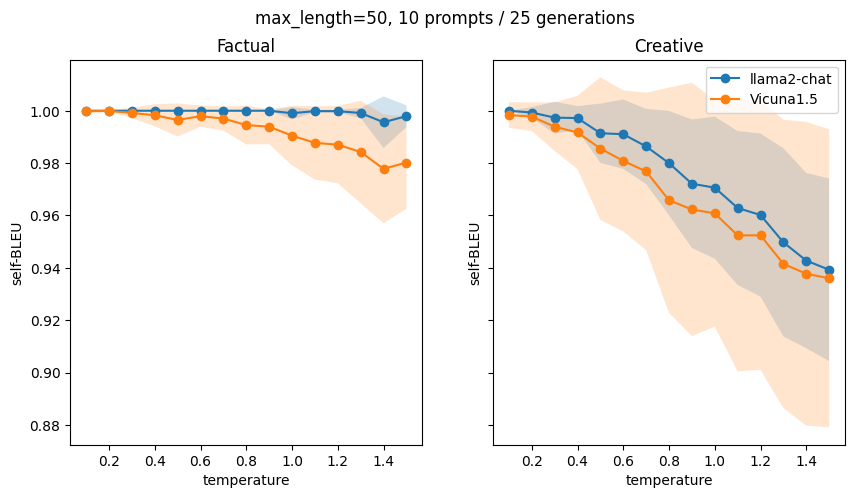

In [121]:
# make two subplots for factual and creative
bleu_scores_factual = np.load('bleu_scores_factual_max_length50.npy')
bleu_scores_creative = np.load('bleu_scores_creative_max_length50.npy')
#bleu_scores_factual = np.load('bleu_scores_factual.npy')
#bleu_scores_creative = np.load('bleu_scores_creative.npy')

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# factual
ax[0].plot(temperatures, bleu_scores_factual[:, :, 0].mean(axis=1), label='llama2-chat', marker='o')
ax[0].plot(temperatures, bleu_scores_factual[:, :, 1].mean(axis=1), label='Vicuna1.5', marker='o')
# ribbons with the same color as the lines
ax[0].fill_between(temperatures, bleu_scores_factual[:, :, 0].mean(axis=1) - bleu_scores_factual[:, :, 0].std(axis=1), bleu_scores_factual[:, :, 0].mean(axis=1) + bleu_scores_factual[:, :, 0].std(axis=1), alpha=0.2)
ax[0].fill_between(temperatures, bleu_scores_factual[:, :, 1].mean(axis=1) - bleu_scores_factual[:, :, 1].std(axis=1), bleu_scores_factual[:, :, 1].mean(axis=1) + bleu_scores_factual[:, :, 1].std(axis=1), alpha=0.2)

ax[0].set_title('Factual')
ax[0].set_xlabel('temperature')
ax[0].set_ylabel('self-BLEU')

# creative
ax[1].plot(temperatures, bleu_scores_creative[:, :, 0].mean(axis=1), label='llama2-chat', marker='o')
ax[1].plot(temperatures, bleu_scores_creative[:, :, 1].mean(axis=1), label='Vicuna1.5', marker='o')
# ribbons with the same color as the lines
ax[1].fill_between(temperatures, bleu_scores_creative[:, :, 0].mean(axis=1) - bleu_scores_creative[:, :, 0].std(axis=1), bleu_scores_creative[:, :, 0].mean(axis=1) + bleu_scores_creative[:, :, 0].std(axis=1), alpha=0.2)
ax[1].fill_between(temperatures, bleu_scores_creative[:, :, 1].mean(axis=1) - bleu_scores_creative[:, :, 1].std(axis=1), bleu_scores_creative[:, :, 1].mean(axis=1) + bleu_scores_creative[:, :, 1].std(axis=1), alpha=0.2)

ax[1].set_title('Creative')
ax[1].set_xlabel('temperature')
ax[1].set_ylabel('self-BLEU')
# global title
fig.suptitle('max_length=50, 10 prompts / 25 generations')
plt.legend()

In [23]:
samples = ['Of course! I\'d be happy to help you invent an original recipe. Here\'s a recipe for a delicious and unique dish that I came up with:\n"Sunset Sprinkle Surprise"\nIngredients:\n* 1 cup of quinoa\n* 1 cup of chopped vegetables (such as bell peppers, carrots, and zucchini)\n* 1/2 cup of cooked chickpeas\n* 1/4 cup of chopped fresh herbs (such as parsley, cilantro, and basil)\n* 2 tablespoons of olive oil\n* 1 tablespoon of lemon', "Of course! I'd be happy to help you with that. Here's an original recipe I came up with:\nSolar-Powered Sunset Soup\n\nIngredients:\n\n* 1 tablespoon of warm sunshine\n* 2 cups of freshly picked wildflowers\n* 3 sprigs of rosemary, chopped\n* 1/4 teaspoon of crushed sea salt\n* 1/4 teaspoon of black pepper\n* 1/4 teaspoon of paprika\n* 1 tablespoon of honey\n* 1/4 cup of pure rainwater\n\nInstructions:\n\n", "Of course, I'd be happy to help you with that! Here's an original recipe I came up with:\n**Solar Flare Soup**\nIngredients:\n* 1 tablespoon of stardust (optional)\n* 2 cups of sunlight (freshly harvested from a nearby sunbeam)\n* 1/2 cup of cosmic rays (dried and ground into a fine powder)\n* 1/4 cup of nebula gas (chopped and sautéed in a zero-gravity pan)\n* 1/4 teaspoon of galaxy dust (mixed with a dash of interstellar sparkles", 'Of course, I\'d be happy to help you with that! Here\'s an original recipe I came up with:\n"Sunset Bliss Smoothie"\nIngredients:\n* 1 cup frozen pineapple chunks\n* 1/2 cup frozen mango chunks\n* 1/2 cup plain Greek yogurt\n* 1/4 cup almond milk\n* 1 tablespoon honey\n* 1/2 teaspoon vanilla extract\n* 1/4 teaspoon turmeric powder (for an extra boost of antioxidants)\n* Ice cubes (optional)\nInstructions:\n1', "Of course! I'd be happy to help you invent an original recipe. Can you please provide me with some information or preferences regarding the recipe? For example, is there a particular type of cuisine or dish you're interested in creating? Do you have any dietary restrictions or preferences? Are there any specific ingredients you'd like to include or avoid? The more details you can provide, the better I can assist you in creating a unique and delicious recipe!", 'Of course, I\'d be happy to help you with that! Here\'s an original recipe I came up with:\n"Sunrise in a Bowl" - A Delicious and Nutritious Breakfast Bowl\nIngredients:\n* 1 cup cooked quinoa\n* 1 cup mixed berries (such as blueberries, strawberries, and raspberries)\n* 1/2 cup chopped fresh pineapple\n* 1/2 cup diced mango\n* 1/4 cup chopped walnuts\n* 1/4 cup crumbled feta cheese\n* 1 tablespoon honey\n* 1 tablespo', 'Of course, I\'d be happy to help you with that! Here\'s an original recipe I came up with:\n"Sunset Bliss Soup"\nIngredients:\n* 1 tablespoon of positivity\n* 2 cups of freshly picked wildflowers\n* 1/2 cup of ocean water (from a safe and sustainable source)\n* 1/4 cup of glitter (biodegradable and safe for the environment)\n* 1/4 teaspoon of gratitude\n* 1/4 teaspoon of kindness\n* 1/4 teaspoon of compassion\n* 1/4 teas', "Of course! I'd be happy to help you invent an original recipe. Can you please provide me with some details or preferences you have in mind for the recipe? For example, do you want it to be sweet or savory, vegetarian or non-vegetarian, or any specific ingredients you would like to include? The more information you provide, the better I can tailor the recipe to your taste.", 'Of course! I\'d be happy to help you with that. Here\'s an original recipe for a delicious and healthy dish that you might enjoy:\n"Sunrise Smoothie Bowl"\nIngredients:\n* 1/2 cup frozen mixed berries (such as blueberries, strawberries, and raspberries)\n* 1/2 cup frozen pineapple chunks\n* 1/2 cup unsweetened almond milk\n* 1/4 cup plain Greek yogurt\n* 1 tablespoon chia seeds\n* 1 tablespoon honey (or to taste)\n* 1/4 te', 'Of course, I\'d be happy to help you with that! Here\'s an original recipe I came up with:\n"Solar Flare Soup"\n\nIngredients:\n\n* 1 tablespoon of pure honey\n* 2 cups of freshly squeezed solar power\n* 1 teaspoon of radiant energy\n* 1 pinch of intergalactic dust\n* 1/2 teaspoon of cosmic rays\n* 1/4 teaspoon of extraterrestrial oomph\n\nInstructions:\n\n1. In a futuristic kitchen, combine the honey, solar power, radiant energy,', 'Of course, I\'d be happy to help you with that! Here\'s an original recipe I came up with:\n"Sunrise Bliss Smoothie"\nIngredients:\n* 1 cup frozen mixed berries (blueberries, strawberries, raspberries)\n* 1/2 cup unsweetened almond milk\n* 1/2 cup plain Greek yogurt\n* 1 tablespoon chia seeds\n* 1 tablespoon honey\n* 1/2 teaspoon vanilla extract\n* Ice cubes (optional)\nInstructions:\n1. In a blender, combine the frozen ber', "Of course! I'd be happy to help you with that. Here's an original recipe I came up with:\nSunset Bay Shrimp Stir-Fry\n\nIngredients:\n\n* 1 lb large shrimp, peeled and deveined\n* 1 red bell pepper, diced\n* 1 yellow bell pepper, diced\n* 1 small onion, diced\n* 2 cloves garlic, minced\n* 1/4 cup vegan soy sauce\n* 1/4 cup rice vinegar\n* 2 tbsp honey\n* 1 tsp grated ginger\n* 1 t", 'Of course! I\'d be happy to help you invent an original recipe. Here\'s a recipe for a delicious and unique dish that I came up with:\nRecipe Name: "Tropical Sunrise"\nIngredients:\n* 1 cup of brown rice\n* 1 cup of quinoa\n* 1 cup of mixed vegetables (such as peas, carrots, corn, and green beans)\n* 1/2 cup of cherry tomatoes, halved\n* 1/4 cup of chopped fresh pineapple\n* 1/4 cup of chopped fresh mango\n* 1/4 cup of chopped fresh cil', "Of course! I'd be happy to help you with that. Here's an original recipe I came up with:\nSunny Side Up Quinoa Bowls with Roasted Vegetables and Lemon-Tahini Dressing\nIngredients:\n* 1 cup quinoa, rinsed and drained\n* 2 cups water or vegetable broth\n* 1 tablespoon olive oil\n* 1 red bell pepper, seeded and chopped\n* 1 yellow bell pepper, seeded and chopped\n* 1 small red onion, chopped\n* 2 cloves garlic, minced\n* 1 cup cherry tom", 'Of course, I\'d be happy to help you with that! Here\'s an original recipe I came up with:\n"Sunrise in a Bowl" Vegetable and Fruit Smoothie\n\nIngredients:\n\n* 1/2 cup frozen mixed berries (such as blueberries, strawberries, and raspberries)\n* 1/2 cup frozen pineapple chunks\n* 1/2 cup diced fresh carrots\n* 1/2 cup diced fresh beets\n* 1/2 cup plain Greek yogurt\n* 1/4 cup almond milk\n* 1 tablespoon chia se', 'Of course! I\'d be happy to help you with that. Here\'s an original recipe I came up with:\n"Sunrise in a Bowl" Vegetarian Breakfast Bowl\n\nIngredients:\n\n* 1 cup cooked quinoa\n* 1 cup cooked brown rice\n* 1 cup chopped mixed vegetables (such as bell peppers, carrots, zucchini, mushrooms, and cherry tomatoes)\n* 1/2 cup diced avocado\n* 1/4 cup sliced almonds\n* 1 tablespoon olive oil\n* 1 tablespoon honey\n* 1 tables', 'Of course, I\'d be happy to help you with that! Here\'s an original recipe I came up with:\n"Sunset Bliss Smoothie"\nIngredients:\n* 1 cup frozen mixed berries (such as blueberries, strawberries, and raspberries)\n* 1/2 cup frozen pineapple chunks\n* 1/2 cup plain Greek yogurt\n* 1/4 cup unsweetened almond milk\n* 1 tablespoon honey\n* 1/2 teaspoon vanilla extract\n* Ice cubes (optional)\nInstructions:\n1. In a blender,', "Of course, I'd be happy to help you with that! Here's an original recipe that I came up with:\nSunset Blossom Salad\nIngredients:\n* 1 cup mixed greens (arugula, spinach, and lettuce)\n* 1/2 cup cherry tomatoes, halved\n* 1/2 cup sliced red onions\n* 1/4 cup chopped pecans\n* 1/4 cup crumbled feta cheese\n* 1/4 cup chopped fresh cilantro\n* 2 tbsp. olive oil\n* 1 tbsp. lemon juice\n* Salt and", "Of course! I'd be happy to help you with that. Here's an original recipe I came up with:\nSunshine and Happiness Smoothie\n\nIngredients:\n\n* 1/2 cup frozen pineapple chunks\n* 1/2 cup frozen mango chunks\n* 1/4 cup frozen berries (such as blueberries, strawberries, or raspberries)\n* 1/4 cup plain Greek yogurt\n* 1/4 cup unsweetened almond milk\n* 1 tablespoon honey\n* 1/2 teaspoon vanilla extract\n* Ice cub", "Of course! I'd be happy to help you with that. Here's an original recipe for a delicious and healthy dish that you might enjoy:\nRecipe: Quinoa and Vegetable Stir-Fry with Tahini Sauce\nIngredients:\n* 1 cup quinoa, rinsed and drained\n* 2 cups water or vegetable broth\n* 1 tablespoon olive oil\n* 1 onion, diced\n* 2 cloves garlic, minced\n* 1 red bell pepper, diced\n* 1 zucchini, diced\n* 1 cup mixed vegetables (such as bro", "Of course! I'd be happy to help you with that. Can you please provide me with more details about the recipe you would like me to invent? For example, what type of dish are you interested in creating? Do you have any dietary restrictions or preferences? Do you want the recipe to be vegetarian, vegan, gluten-free, or something else? Any other details you can provide will help me create a unique and delicious recipe for you!", "Of course! I'd be happy to help you invent an original recipe. Can you please provide me with some details about the recipe you would like to create? For example, what type of dish are you interested in making (e.g. appetizer, main course, dessert)? What are the ingredients you would like to include? Are there any dietary restrictions or preferences you would like to consider?", "Of course, I'd be happy to help you with that! Here's an original recipe I came up with:\nSunshine and Happiness Breakfast Burritos\n\nIngredients:\n\n* 1 cup of cooked and cooled oatmeal\n* 1/2 cup of fresh berries (such as blueberries, strawberries, or raspberries)\n* 1/4 cup of chopped nuts (such as almonds or walnuts)\n* 1 tablespoon of honey or maple syrup (optional)\n* 1 tablespoon of unsweetened almond milk or other non-da", 'Of course, I\'d be happy to help you with that! Here\'s an original recipe I came up with:\n"Sunrise in a Bowl" Breakfast Bowl\nIngredients:\n* 1 cup cooked oatmeal\n* 1/2 cup fresh berries (such as blueberries, strawberries, or raspberries)\n* 1/4 cup sliced almonds\n* 1/4 cup shredded coconut\n* 1 tablespoon honey\n* 1 tablespoon almond butter\n* 1 tablespoon chia seeds\n* 1/2 cup unsweetened cocon', 'Of course! I\'d be happy to help you with that. Here\'s an original recipe I came up with:\n"Sunset Bliss Salad"\nIngredients:\n* 4 cups mixed greens (kale, spinach, arugula)\n* 1 cup cherry tomatoes, halved\n* 1/2 cup sliced red onion\n* 1/4 cup chopped fresh cilantro\n* 1/4 cup crumbled feta cheese\n* 1/4 cup chopped almonds\n* 2 tbsp olive oil\n* 2 tbsp apple cider vinegar\n* Salt and pe']

In [25]:
print(samples[1])

Of course! I'd be happy to help you with that. Here's an original recipe I came up with:
Solar-Powered Sunset Soup

Ingredients:

* 1 tablespoon of warm sunshine
* 2 cups of freshly picked wildflowers
* 3 sprigs of rosemary, chopped
* 1/4 teaspoon of crushed sea salt
* 1/4 teaspoon of black pepper
* 1/4 teaspoon of paprika
* 1 tablespoon of honey
* 1/4 cup of pure rainwater

Instructions:




In [26]:
print(samples[2])

Of course, I'd be happy to help you with that! Here's an original recipe I came up with:
**Solar Flare Soup**
Ingredients:
* 1 tablespoon of stardust (optional)
* 2 cups of sunlight (freshly harvested from a nearby sunbeam)
* 1/2 cup of cosmic rays (dried and ground into a fine powder)
* 1/4 cup of nebula gas (chopped and sautéed in a zero-gravity pan)
* 1/4 teaspoon of galaxy dust (mixed with a dash of interstellar sparkles


In [29]:
self_BLEU(samples[:5])

0.681530677301768

In [ ]:
str1 = "Paris"
str2 = "ParisParis"

# compute BLEU score using nltk
from nltk.translate.bleu_score import sentence_bleu
sentence_bleu([str1], str2)
